# Assignment 3

> Group Members: Alexandros Gilch, Paul Grass, Tim Mensinger, Philipp Schirmer

## Question I: Crises

In this notebook our group aims to answer the question whether financial crises can be predicted using past data. Again, the notebook is structured as follows: We first import all functions that are implemented in a seperate module. Then, in the results section we then answer questions *i. - iii*. At last we list the code of the module.

Once more we remark that the code section may be skipped by everyone uninterested in the implementation, and that this notebook is best enjoyed [online](https://nbviewer.jupyter.org/github/timmens/macro_problems/blob/main/assignment3.ipynb?flush_cache=False).  

---

## Results

### i.

In [1]:
from auxiliary import *

df = read_and_clean_data()

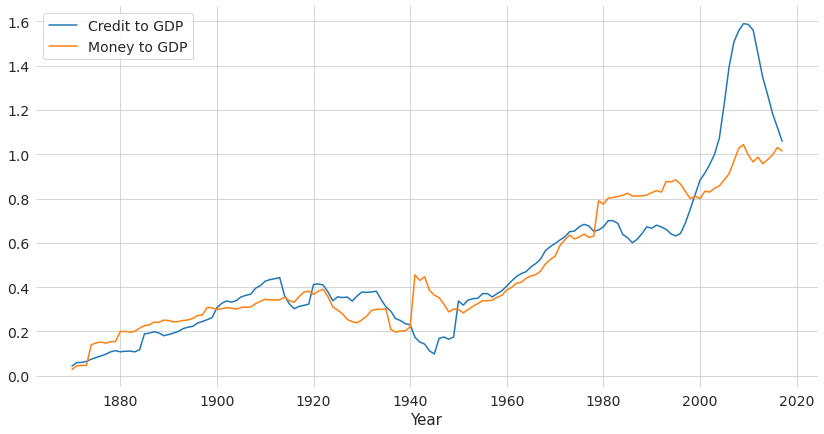

In [2]:
df_agg = compute_aggregate_credit_and_money(df)

plot_aggregate_credit_and_money(df_agg)

### ii.

Below we fit a logit fixed effects model with 5 lags of log changes in real credit as an additional predictor. To answer **ii.1**, the p-value of an f-test for joint significance of the five lags of real credit growth is given below as ~1.5e-5. That is we can reject the null hypothesis of no effect with great confidence. We then print that coefficient estimates, standard errors and standard pvalues (i.e. non corrected for multiple-testing problems) for the coefficients of the five lags of real credit growth. Below that we print the fixed effect estimates. Since we include an intercept in the regression the fixed effects are relative to the country left out, which in our case is USA.

In [3]:
formula = "crisisJST ~ C(ifs) + " + create_formula_with_lags("diff_log_real_credit", 5)

y, X = create_model_data(formula, df)

model = fit_logit(y, X, backend="statsmodels")

In [4]:
f_test_pvalue, params, fixed_effects = extract_info_from_statsmodels_fit(model, df)

In [5]:
f_test_pvalue

6.51402668550305e-07

In [6]:
params

,coef,se,pvalue
Lag,,,
1,1.062679,1.246715,3.940014e-01
2,5.542023,1.089714,3.661618e-07
3,-0.241261,0.098925,1.473544e-02
4,0.305101,0.579162,5.983352e-01
5,0.701906,0.927231,4.490549e-01


In [7]:
fixed_effects

,coef,se,pvalue
country,,,
UK,-0.208926,0.684654,0.760248
Belgium,0.330508,0.649003,0.610574
Denmark,0.085535,0.619747,0.890228
France,-0.830577,0.865253,0.337093
Germany,-0.278321,0.667320,0.676626
Italy,0.327526,0.580155,0.572380
Netherlands,-0.841021,0.848713,0.321717
Norway,-0.351245,0.683981,0.607580
Sweden,0.155336,0.619436,0.801992


### iii.: Model Evaluation

#### iii.1

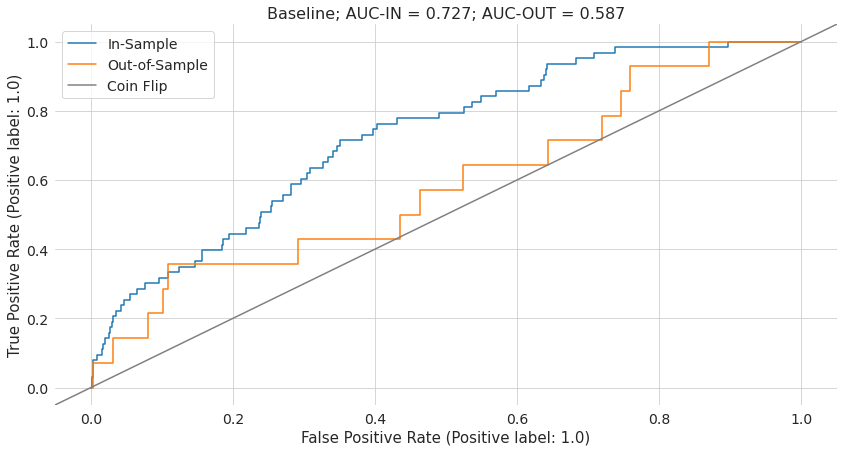

In [8]:
data = create_test_train_data(df, formula)

model = fit_logit(data=data, backend="sklearn")

baseline_plot = plot_roc_curve(model, **data, title="Baseline")

#### iii.2 and iii.3

We start by plotting the ROC curves for the baseline specification and the additional variables. 

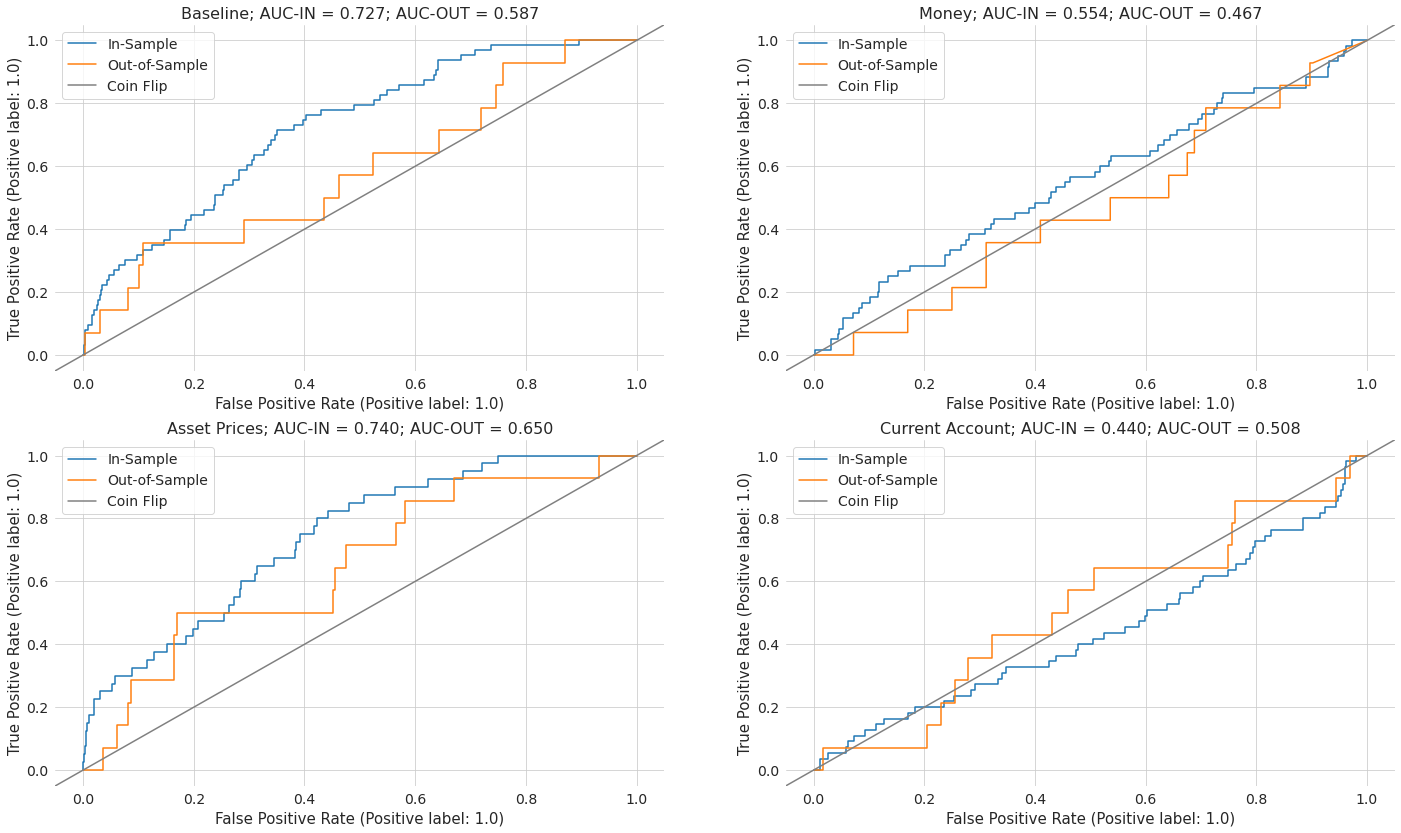

In [9]:
plot_predictor_comparison(fit_logit, df, formula, backend="sklearn", max_iter=10_000)

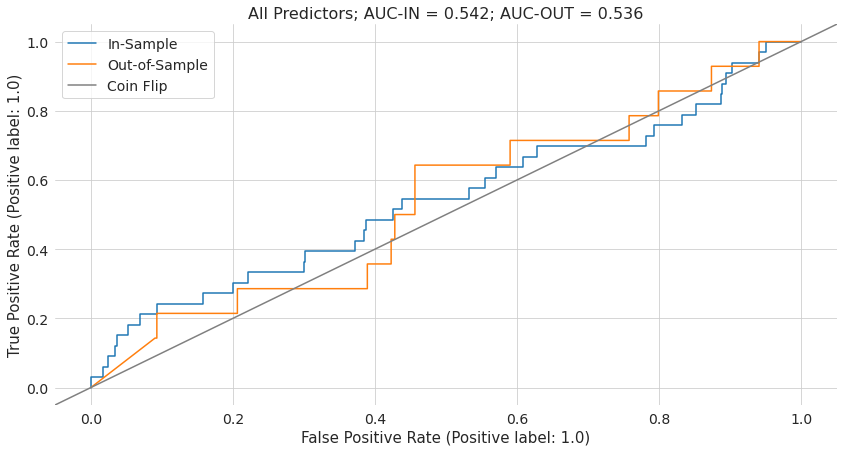

In [10]:
with_predictors = [
    f"{var}.shift({lag})" for var in ("money", "hpnom", "ca") for lag in range(1, 7)
]

data = create_test_train_data(df, formula, with_predictors=with_predictors)

model = fit_logit(data=data, backend="sklearn", max_iter=10_000)
plot_roc_curve(model, **data, title="All Predictors")

## Neural Networks

A trivial extension to the above method is to use a more flexible classifier. In this section we focus on a neural network classifier with a 100-40-20 hidden layer architecture with ReLu activation function. As with the classical logistic regression, the model using only asset prices achieves the highest out-of-sample roc-auc score. However, the neural network gives a score of ~0.73 which is significantly higher than 0.65, the best logistic regression score.

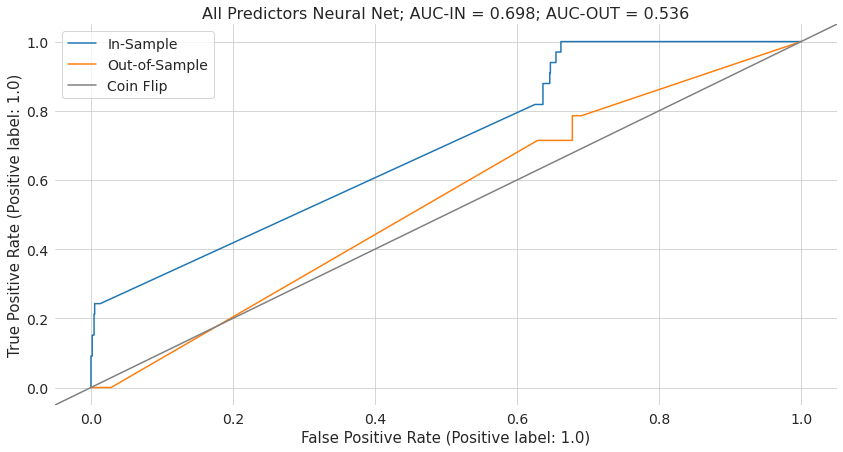

In [11]:
model = fit_neural_network(data=data, layers="100-40-20")
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plot_roc_curve(model, **data, title="All Predictors Neural Net")

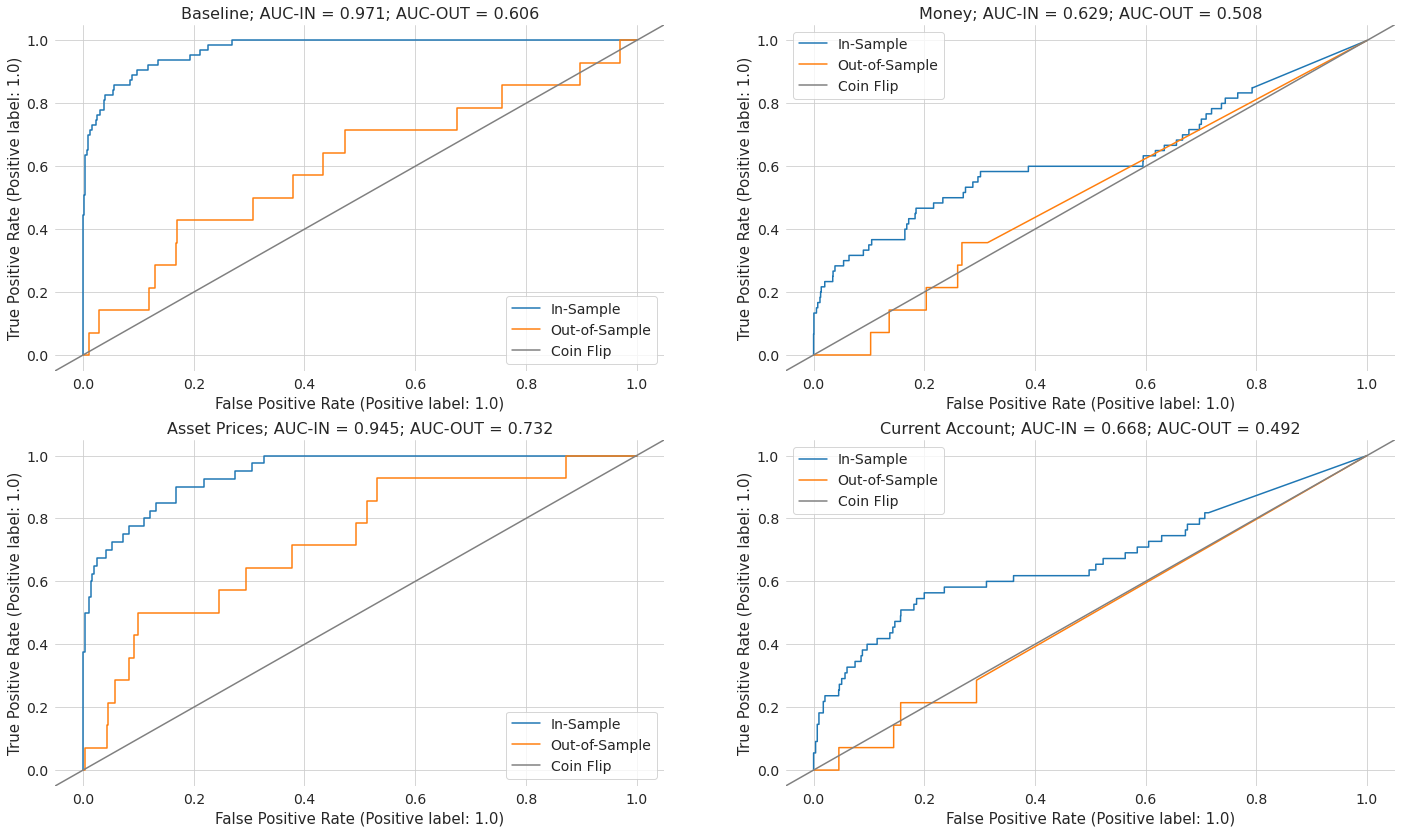

In [12]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plot_predictor_comparison(fit_neural_network, df, formula, layers="100-40-20")

---
## Code